In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
%matplotlib inline

# Our model

We observe $X_i$, which is the number of messages arrived at a certain location at day $i$ with $i \in \{0,...,n-1\}$, so that we have $n$ days.

We were usually receiving the messages following $\sim \text{Poisson}(2)$, but after a certain day the behaviour changed and we received more messages per day, following $\sim \text{Poisson}(4)$.


$$\begin{align*}
\tau &\in (0,1)\\
\text{for }  i &= 1\ldots N: \\
X_i &= \begin{cases} \text{Poisson}(2), & \tau > i/N \\ \text{Poisson}(4), & \text{otherwise}\end{cases}\\
\end{align*}$$


In [2]:
# real (and unknown) parameter
real_tau = 0.8

# possible range of values for tau
tau_support = 0,1

We encapsule our model in a class. The two main things we have to provide are:
    
- a way to take samples, `rvs`
- a way to compute the probability of a sample `logprob`

Observe we are using log probabilities, to handle very very small probability values arising when multiplying probabilities of all data points. This way


$$\log P(\tau|X) = \log \Bigg[\frac{P(X|\tau)P(\tau)}{P(X)}\Bigg] = \log P(X|\tau) + \log P(\tau) - \log P(X)$$

In [53]:
class TModel:
        
    poisson_A = stats.poisson(2)
    poisson_B = stats.poisson(4)

    def __init__(self, tau):        
        assert tau>=0 and tau<=1        
        self.tau = tau
        
    def rvs(self, n):
        n1 = int(n*self.tau)        
        r = list(self.poisson_A.rvs(n1)) + list(self.poisson_B.rvs(n - n1))
        return r
    
    def logprob(self, x):
        n = int(len(x)*self.tau)
        return np.sum(np.log(self.poisson_A.pmf(x[:n]))) + np.sum(np.log(self.poisson_B.pmf(x[n:])))    
    
    # loglikelihood on tau
    @classmethod
    def loglikelihood(cls, tau, x):
        return cls(tau).logprob(x)
    

# our observations

In [108]:
x = TModel(tau=real_tau).rvs(30)

In [109]:
# fix the likelihood to the observed data, so that it is
# only a function of tau
loglikelihood = lambda tau: TModel.loglikelihood(tau, x)

Text(0.5, 0, '$\\tau$')

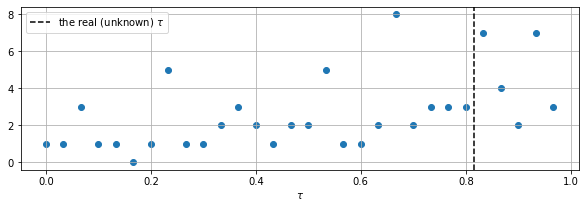

In [110]:
plt.figure(figsize=(10,3))
plt.scatter(np.arange(len(x))/len(x), x)
plt.axvline((real_tau*len(x)+.5)/len(x), ls="--", color="black", label=r"the real (unknown) $\tau$")
plt.grid(); plt.legend();
plt.xlabel(r"$\tau$")

In [111]:
TModel.loglikelihood(0.2, x)

-60.731620116644216

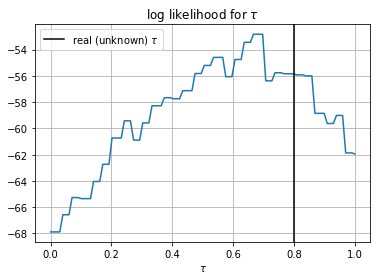

In [112]:
rtau = np.linspace(*tau_support, 100)
plt.plot(rtau, [loglikelihood(tau) for tau in rtau])
plt.axvline(real_tau, color="black", label=r"real (unknown) $\tau$")
plt.legend();
plt.grid(); plt.xlabel(r"$\tau$"); plt.title(r"log likelihood for $\tau$");

# probability functions


Observe how we compute the normalization factor in `get_logposterior_fn` very naively with **Montecarlo integration**. This will have its limitations if our problem gets more complex even if it is very slightly.

In [113]:
# the posterior (using Bayes theorem)
def get_logposterior_fn(loglikelihood_fn, logprior_fn, support, integration_intervals=1000):
    assert len(support)==2

    # Montecarlo computation of the integral
    xr = np.linspace(*support, integration_intervals)
    Z = np.log(np.sum([np.exp(loglikelihood_fn(x) + logprior_fn(x)) for x in xr]) * (xr[1]-xr[0]))
    
    posterior_fn = lambda x: loglikelihood_fn(x) + logprior_fn(x) -  Z
    return posterior_fn

The plots below show **both** probabilities and log probabilities for comparison.


In [114]:
def plot_logprobs(logprior, logposterior):
    rtau = np.linspace(*tau_support,100)

    for ax,i in subplots(4, usizex=5, n_cols=2):
        if i in [0,2]:
            p = logprior if i==0 else lambda x: np.exp(logprior(x))
            plt.plot(rtau, [p(tau) for tau in rtau])
            plt.grid();   
            plt.title(("log " if i==0 else "")+"prior probability")
        if i in [1,3]:
            p = logposterior if i==1 else lambda x: np.exp(logposterior(x))
            plt.plot(rtau, [p(tau) for tau in rtau])
            plt.axvline(real_tau, color="black", label=r"real (unknown) $\tau$")
            plt.title(("log " if i==1 else "")+"posterior probability")
            plt.grid(); plt.legend();

        plt.xlabel(r"$\tau$")
    plt.tight_layout()

# a uniform (uninformative) prior on tau

We use uniform distribution on the interval $(0,1)$ as a prior on $\tau$: 

$$\tau \sim \text{Uniform}(0,1)$$

Observe the postierior has the same shape as the likelihood. This is because:

- the prior on $\tau$ is a uniform distribution, so $P(\tau)=1$, $\forall \tau \in (0,1)$
- the likelihood $P(X|\tau)$ is **not a distribution** of $\tau$ (it is a distribution of $X$) and therefore it does not integrate to 1 over $\tau$. Remember that we are keeping $X$ fixed which is our data. The normalization constant in Bayes theorem makes the posterior a distribution of $\tau$.


$$P(\tau|X) = \frac{P(X|\tau)P(\tau)}{P(X)} = \frac{P(X|\tau) P(\tau)}{\int P(X|\tau)P(\tau) d\tau} = \frac{P(X|\tau)}{\int P(X|\tau) d\tau}$$

In [115]:
logprior = lambda tau: np.log(stats.uniform(*tau_support).pdf(tau))

In [116]:
logposterior = get_logposterior_fn(loglikelihood, logprior, tau_support)

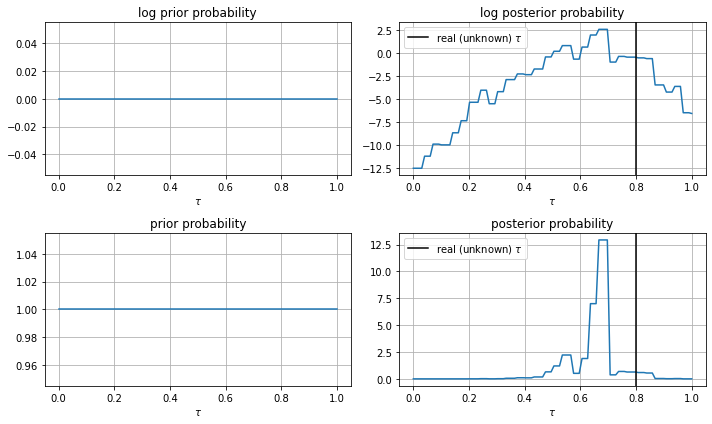

In [117]:
plot_logprobs(logprior, logposterior)

In [118]:
## check the integral of the posterior adds up to 1
## we do this for sanity, as numerical errors computing the 
## integral in bayes theorem might arise very easily
rtau = np.linspace(*tau_support,1000)
np.sum([np.exp(logposterior(tau))/len(rtau) for tau in rtau])

0.9990000000000011

# a very extreme and wrong prior on tau

observe now how the posterior:

- has a different shape from the likelihood, since $P(\tau)$ is not constant.
- is biased towards the prior.

In [119]:
unnormalized_prior = lambda x: (1-x+.01)**20
Z = quad(unnormalized_prior, *tau_support)[0]
logprior = lambda x: np.log(unnormalized_prior(x)/Z)

In [120]:
logposterior = get_logposterior_fn(loglikelihood, logprior, tau_support)

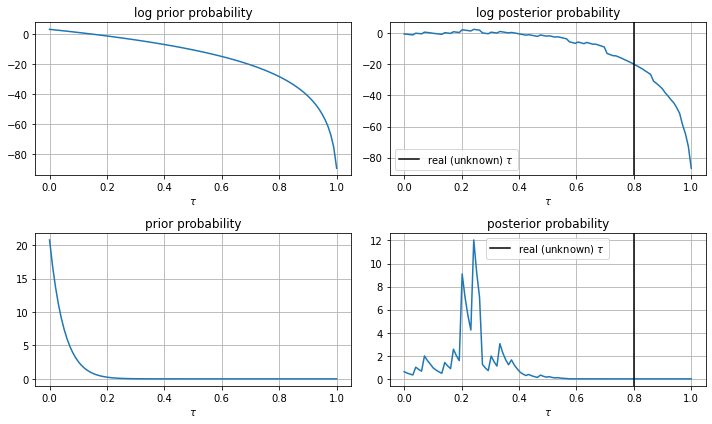

In [121]:
plot_logprobs(logprior, logposterior)

In [122]:
## check the integral of the posterior adds up to 1
rtau = np.linspace(*tau_support,1000)
np.sum([np.exp(logposterior(tau))/len(rtau) for tau in rtau])

0.9990000000000016

# increased data overcomes very wrong priors

Question: from how many data points the posterior has a maximum around the real $\tau$?

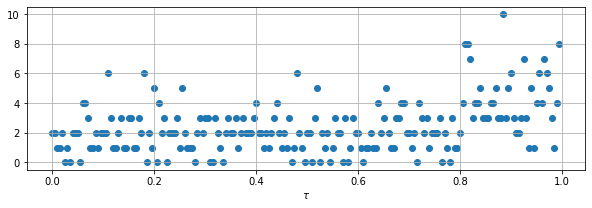

In [123]:
x = TModel(tau=real_tau).rvs(200)
plt.figure(figsize=(10,3))
plt.scatter(np.arange(len(x))/len(x), x)
#plt.axvline((real_tau*len(x)+.5)/len(x), ls="--", color="black")
plt.xlabel(r"$\tau$")
plt.grid();

In [124]:
logposterior = get_logposterior_fn(loglikelihood, logprior, tau_support)

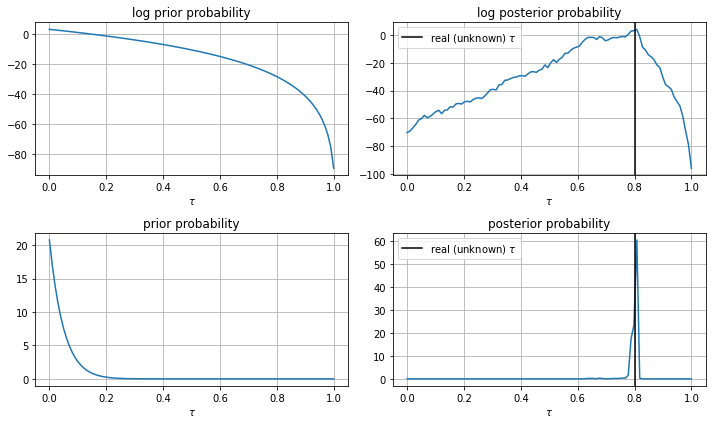

In [125]:
plot_logprobs(logprior, logposterior)

In [73]:
## check the integral of the posterior adds up to 1
rtau = np.linspace(*tau_support,1000)
np.sum([np.exp(logposterior(tau))/len(rtau) for tau in rtau])

0.999000000000018